# Calibration of household transmissions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.special import gamma
from os.path import join

# custom functions
import calibration_functions as cf

In [12]:
dst = '../../data/calibration/simulation_results'

According to a [recent meta study](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2774102), household transmissions risk between adulty (secondary attack rate) is $\text{SAR}_\text{literature}=37.8$ %. To calibrate the base transmission risk $r_b$ between two adults in a household, we simulate household transmissions for our setting in which the transmission risk is declining with infection duration.

## Transmission risk modification due to infection progression

In our simulation, the base transmission risk is multiplied with a modifier $m(\text{day})$, which is 1 until symptom onset and then linearly decreases until it reaches zero at the time that corresponds to the infection duration (as depicted below).

In [3]:
def get_transmission_risk_time_modifier(exposure_duration, time_until_symptoms,
                                       infection_duration, days_since_exposure):
    '''
    Given an agents exposure duration, time until symptom onset and infection
    duration, returns the modifier to the transmission risk, based on the 
    progression of the infection (days since exposure).
    '''
    asymptomatic_infectious = time_until_symptoms - exposure_duration
    
    try:
        modifier = 1 - max(0, days_since_exposure - asymptomatic_infectious) / \
                    (infection_duration - asymptomatic_infectious)
    except ZeroDivisionError:
        return 1
    return modifier

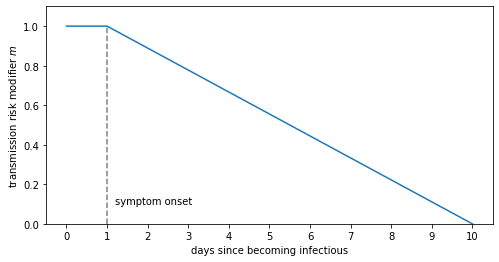

In [4]:
# illustration of the decline of transmission risk with infection progression
infection_duration = 10
exposure_duration = 5
time_until_symptoms = 6
asymptomatic_infectious = time_until_symptoms - exposure_duration

x = np.arange(0, infection_duration + 1)
y = [get_transmission_risk_time_modifier(exposure_duration, time_until_symptoms,
                                         infection_duration, i) for i in x]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.plot([asymptomatic_infectious, asymptomatic_infectious], [0, 1],
        '--', color='grey')
ax.text(asymptomatic_infectious + 0.2, 0.1, 'symptom onset')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_ylabel('transmission risk modifier $m$')
ax.set_xlabel('days since becoming infectious')
ax.set_ylim(0, 1.1);

## Base transmission risk calibration

To the base transmission risk calibrate $r_b$, we implement the following steps:
1. We create two agents with epidemiological parameters (exposure time, time until symptoms, infection duration) drawn from the random distributions used for the simulation study. 
2. We define one of the two individuals as the index case and simulate a number of days equal to the infection duration of the index case. On every day, the other agent has a chance of $r_b \cdot m(\text{day})$ of becoming infected.
3. We repeat this simulation a number of times and calculate the secondary attack rate $\text{SAR}_\text{simulation}$ as the average of the number of times the second agent has become infected.

We vary $r_b$ for a range of realistic values and repeat steps 1-3. We then chose the value for $r_b$ that minimizes $|\text{SAR}_\text{literature} - \text{SAR}_\text{simulation}|$.

In [8]:
### household transmission simulation
runs = range(0, 10000)

# grid from which base transmission risks are sampled
base_transmission_risks = np.arange(0.06, 0.08, 0.001)
results = pd.DataFrame()
results['transmission'] = [np.nan] * len(runs) * len(base_transmission_risks)
iterables = [base_transmission_risks, runs]
index = pd.MultiIndex.from_product(iterables, \
                    names=['base_transmission_risk', 'run'])
results.index = index

for base_transmission_risk in base_transmission_risks:
    for run in runs:
        infected = cf.get_epi_params()
        transmission_occured = 0
        
        # Note: starts at day 1, to reflect the simulation implementation
        for day in range(1, infected['infection_duration'] + 1):
            modifier = get_transmission_risk_time_modifier(\
                infected['exposure_duration'], infected['time_until_symptoms'],
                infected['infection_duration'], day)
            modified_transmission_risk = 1 - base_transmission_risk * modifier
            transmission = np.random.random()
            if transmission > modified_transmission_risk:
                transmission_occured = 1
                break
            
        results.loc[base_transmission_risk, run]['transmission'] = \
        transmission_occured

# save simulation results
results = results.reset_index()
results.to_csv(join(dst,'household_transmission_base_risk_scan.csv'),
              index=False)

In [13]:
# load and aggregate simulation results
results = pd.read_csv(join(dst, 'household_transmission_base_risk_scan.csv'))
results_mean = results[['base_transmission_risk', 'transmission']]\
    .groupby('base_transmission_risk')\
    .agg({'transmission':['mean', 'std']})
results_mean.head(3)

transmission          
                               mean       std
base_transmission_risk                       
0.060                        0.3148  0.464459
0.061                        0.3317  0.470847
0.062                        0.3302  0.470308

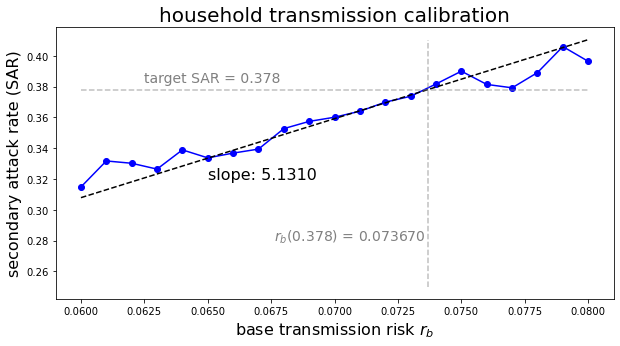

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results_mean.index, results_mean['transmission']['mean'], 'o-', color='b')

# regression with zero intercept
x = results_mean.index.values
x = x[:, np.newaxis]
y = results_mean['transmission']['mean'].values
slope, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
slope = slope[0]

ax.plot(results_mean.index, slope * results_mean.index, '--', color='k')
ax.set_xlabel('base transmission risk $r_b$', fontsize=16)
ax.set_ylabel('secondary attack rate (SAR)', fontsize=16)
ax.text(0.065, 0.32, 'slope: {:1.4f}'.format(slope), fontsize=16)
ax.set_title('household transmission calibration', fontsize=20)

target_attack_rate = 0.378
target_base_transmission_risk = float(target_attack_rate / slope)
ax.plot([0.06, 0.08],[target_attack_rate, target_attack_rate], \
        '--', color='grey', alpha=0.5)
ax.text(0.0625, 0.383, 'target SAR = 0.378', color='grey', fontsize=14)
ax.plot([target_base_transmission_risk, target_base_transmission_risk],
        [0.25, 0.41], '--', color='grey', alpha=0.5)

ax.text(0.0676, 0.28, '$r_b(0.378)$ = {:1.6f}'\
        .format(target_base_transmission_risk), color='grey', fontsize=14);

In [15]:
print('optimal base transmission risk for household transmissions is: {:1.6f}'\
      .format(target_base_transmission_risk))

optimal base transmission risk for household transmissions is: 0.073670
